# Given a sequence of 50 numbers belonging to a sine wave, predict the 51st number in the series

https://www.analyticsvidhya.com/blog/2019/01/fundamentals-deep-learning-recurrent-neural-networks-scratch-python/

In [1]:
# import the necessities

%pylab inline
import math

# note: when I run the script without this line, it still works for me
# I'm not sure if that is a happy accident
# probably best to import anyways
import numpy as np

# make the graphs larger for fun
plt.rcParams["figure.figsize"] = (18,8)

Populating the interactive namespace from numpy and matplotlib


# Data Preparation

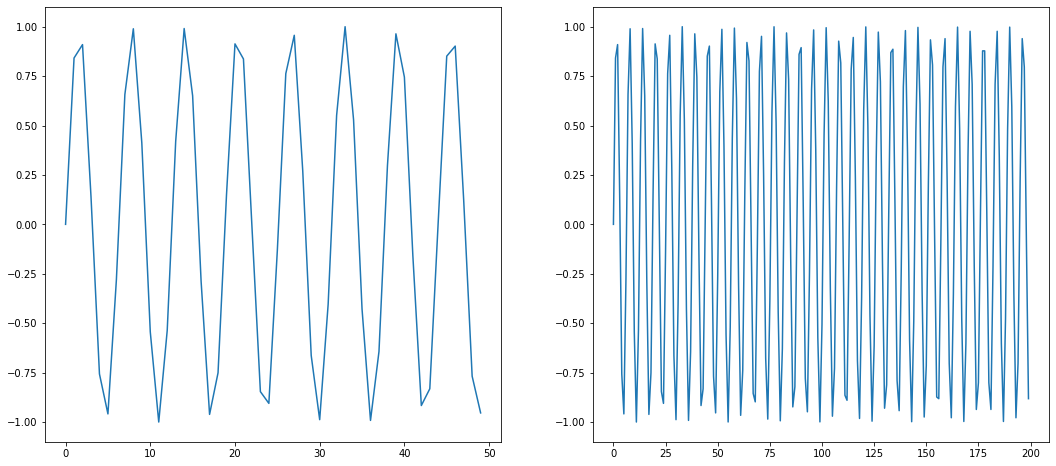

In [2]:
# make the sine wave data
sin_wave = np.array([math.sin(x) for x in np.arange(200)])

# visualize the data
plt.subplot(1, 2, 1)
plt.plot(sin_wave[:50])
plt.subplot(1, 2, 2)
plt.plot(sin_wave[:200])
plt.show()

In [3]:
# create the dataset

# initialize X and Y
X = []
Y = []

# the input will be a single sequence of length 50
seq_len = 50
num_records = len(sin_wave) - seq_len # 200 - 50

# this loop goes through each consecutive sequence of 50 points and stores each sequence in X as an observation and each
# point following the sequence as the label in Y (goal is to predice the 51st data point)
for i in range(num_records - 50):# loop for (num_records – 50) because we want to set aside 50 points as validation data
    X.append(sin_wave[i:i+seq_len])
    Y.append(sin_wave[i+seq_len])

# reshape X
X = np.array(X)
X = np.expand_dims(X, axis=2) 

# reshape Y
Y = np.array(Y)
Y = np.expand_dims(Y, axis=1)

# check out the shape
X.shape, Y.shape

((100, 50, 1), (100, 1))

In [4]:
# create the validation set

# initialize data and labels
X_val = []
Y_val = []

# start the loop where we left off when we created the training data and go all the way to the end of the sine data
for i in range(num_records - 50, num_records):
    X_val.append(sin_wave[i:i+seq_len])
    Y_val.append(sin_wave[i+seq_len])

# reshape X_val
X_val = np.array(X_val)
X_val = np.expand_dims(X_val, axis=2)

# reshape Y_val
Y_val = np.array(Y_val)
Y_val = np.expand_dims(Y_val, axis=1)

# Set Up the Architecture for the RNN Model

Define all the necessary variables and functions we’ll use in the RNN model.
The model will take in the input sequence, process it through a hidden layer of 100 units, and produce a single valued output.

In [5]:
# define the model variables

learning_rate = 0.0001    
nepoch = 25               
T = 50  # length of sequence
hidden_dim = 100         
output_dim = 1

bptt_truncate = 5
min_clip_value = -10
max_clip_value = 10

In [6]:
# initialize the weights

# U is the weight matrix for weights between input and hidden layers
U = np.random.uniform(0, 1, (hidden_dim, T))

# W is the weight matrix for shared weights in the RNN layer (hidden layer)
W = np.random.uniform(0, 1, (hidden_dim, hidden_dim))

# V is the weight matrix for weights between hidden and output layers
V = np.random.uniform(0, 1, (output_dim, hidden_dim))

In [7]:
# define the activation function

def sigmoid(x):
    return 1 / (1 + np.exp(-x))

# Train the Model

Now that we have defined our model, we can finally move on with training it on our sequence data. We can subdivide the training process into smaller steps:

-Check the loss on training data

-Forward Pass

-Calculate Error

-Check the loss on validation data

-Forward Pass

-Calculate Error

-Start actual training

-Forward Pass

-Backpropagate Error

-Update weights

We need to repeat these steps until convergence. If the model starts to overfit, stop! Or simply pre-define the number of epochs.

In [8]:
# check the loss on data:
# do a forward pass through the RNN model and calculate the squared error for the predictions for all records 
# in order to get the loss value.

for epoch in range(nepoch):
    
    # check loss on training data
    loss = 0.0
    
    # do a forward pass to get prediction
    for i in range(Y.shape[0]):
        # get input, output values of each record
        x, y = X[i], Y[i]
        # prev-s is the value of the previous activation of hidden layer; which is initialized as all zeroes
        prev_s = np.zeros((hidden_dim, 1))
        # for each point in the sequence of 50:
        for t in range(T):
            # do a forward pass for every timestep in the sequence
            new_input = np.zeros(x.shape) 
            # define a single input for that timestep
            new_input[t] = x[t]
            # multiply the input with the weights between input and hidden layers
            mulu = np.dot(U, new_input)
            # multiplication of weights in the hidden layer
            mulw = np.dot(W, prev_s)
            # add is the sum of the two
            add = mulw + mulu
            # s is y_(t)
            s = sigmoid(add)
            # mulv is the prediction
            mulv = np.dot(V, s)
            # update the hidden state
            prev_s = s

    # calculate error 
        loss_per_record = (y - mulv)**2 / 2
        loss += loss_per_record
    loss = loss / float(y.shape[0])
    
    # check the loss on validation data (same code as first half of loop, but with validation data)
    val_loss = 0.0
    
    for i in range(Y_val.shape[0]):
        x, y = X_val[i], Y_val[i]
        prev_s = np.zeros((hidden_dim, 1))
        for t in range(T):
            new_input = np.zeros(x.shape)
            new_input[t] = x[t]
            mulu = np.dot(U, new_input)
            mulw = np.dot(W, prev_s)
            add = mulw + mulu
            s = sigmoid(add)
            mulv = np.dot(V, s)
            prev_s = s

        loss_per_record = (y - mulv)**2 / 2
        val_loss += loss_per_record
    val_loss = val_loss / float(y.shape[0])

    print('Epoch: ', epoch + 1, ', Loss: ', loss, ', Val Loss: ', val_loss)
    
    # train model
    for i in range(Y.shape[0]):
        # here x is a sequence of 50 and y is the corresponding 51st point
        x, y = X[i], Y[i]
        # dictionary
        layers = []
        # the hidden state, prev_s, starts off with no information in it
        prev_s = np.zeros((hidden_dim, 1))
        # the weights start off as zeros (not always efficient, but this is in the spirit of learning)
        dU = np.zeros(U.shape)
        dV = np.zeros(V.shape)
        dW = np.zeros(W.shape)
        
        dU_t = np.zeros(U.shape)
        dV_t = np.zeros(V.shape)
        dW_t = np.zeros(W.shape)
        
        dU_i = np.zeros(U.shape)
        dW_i = np.zeros(W.shape)
        
        # forward pass
        for t in range(T):
            new_input = np.zeros(x.shape)
            new_input[t] = x[t]
            # multiply the input with the weights between input and hidden layers
            mulu = np.dot(U, new_input)
            # multiplication of weights in the hidden layer
            mulw = np.dot(W, prev_s)
            # sum the two
            add = mulw + mulu
            # activation function value
            s = sigmoid(add)
            # mulv is the prediction
            mulv = np.dot(V, s)
            # Save the state at the current layer and also the state at the previous timestep in a dictionary
            layers.append({'s':s, 'prev_s':prev_s})
            prev_s = s

        # derivative of pred: difference between prediction and actual
        dmulv = (mulv - y)
        
        # backward pass: backpropogating the errors
        '''
        instead of backpropagating through all previous timestep, 
        we backpropagate till x timesteps to save computational power. 
        Consider this ideologically similar to stochastic gradient descent, 
        where we include a batch of data points instead of all the 
        data points.
        '''
        for t in range(T):
            dV_t = np.dot(dmulv, np.transpose(layers[t]['s']))
            dsv = np.dot(np.transpose(V), dmulv)
            
            ds = dsv
            dadd = add * (1 - add) * ds
            
            dmulw = dadd * np.ones_like(mulw)

            dprev_s = np.dot(np.transpose(W), dmulw)


            for i in range(t-1, max(-1, t-bptt_truncate-1), -1):
                ds = dsv + dprev_s
                dadd = add * (1 - add) * ds

                dmulw = dadd * np.ones_like(mulw)
                dmulu = dadd * np.ones_like(mulu)

                dW_i = np.dot(W, layers[t]['prev_s'])
                dprev_s = np.dot(np.transpose(W), dmulw)

                new_input = np.zeros(x.shape)
                new_input[t] = x[t]
                dU_i = np.dot(U, new_input)
                dx = np.dot(np.transpose(U), dmulu)

                dU_t += dU_i
                dW_t += dW_i
            
            # these are the gradients for each of the weight matrices
            dV += dV_t
            dU += dU_t
            dW += dW_t
            
            # regulate the gradients based on the min_clip_value and 
            # max_clip_value that we defined earlier
            if dU.max() > max_clip_value:
                dU[dU > max_clip_value] = max_clip_value
            if dV.max() > max_clip_value:
                dV[dV > max_clip_value] = max_clip_value
            if dW.max() > max_clip_value:
                dW[dW > max_clip_value] = max_clip_value
                
            
            if dU.min() < min_clip_value:
                dU[dU < min_clip_value] = min_clip_value
            if dV.min() < min_clip_value:
                dV[dV < min_clip_value] = min_clip_value
            if dW.min() < min_clip_value:
                dW[dW < min_clip_value] = min_clip_value
        
        # update
        U -= learning_rate * dU
        V -= learning_rate * dV
        W -= learning_rate * dW

Epoch:  1 , Loss:  [[143794.09263569]] , Val Loss:  [[71894.93814592]]
Epoch:  2 , Loss:  [[95171.49204802]] , Val Loss:  [[47584.02362614]]
Epoch:  3 , Loss:  [[56548.89146001]] , Val Loss:  [[28273.1091062]]
Epoch:  4 , Loss:  [[27926.28746786]] , Val Loss:  [[13962.19288305]]
Epoch:  5 , Loss:  [[9283.03528315]] , Val Loss:  [[4640.95192393]]
Epoch:  6 , Loss:  [[191.34667665]] , Val Loss:  [[95.44811163]]
Epoch:  7 , Loss:  [[21.64196133]] , Val Loss:  [[10.77582982]]
Epoch:  8 , Loss:  [[21.96767077]] , Val Loss:  [[10.94942891]]
Epoch:  9 , Loss:  [[22.15795707]] , Val Loss:  [[11.04149117]]
Epoch:  10 , Loss:  [[21.9218355]] , Val Loss:  [[10.91655018]]
Epoch:  11 , Loss:  [[22.33120028]] , Val Loss:  [[11.11954282]]
Epoch:  12 , Loss:  [[21.9252196]] , Val Loss:  [[10.91657782]]
Epoch:  13 , Loss:  [[21.90496421]] , Val Loss:  [[10.91126839]]
Epoch:  14 , Loss:  [[22.98724796]] , Val Loss:  [[11.44153488]]
Epoch:  15 , Loss:  [[21.87715478]] , Val Loss:  [[10.89811646]]
Epoch: 

# Get the predictions

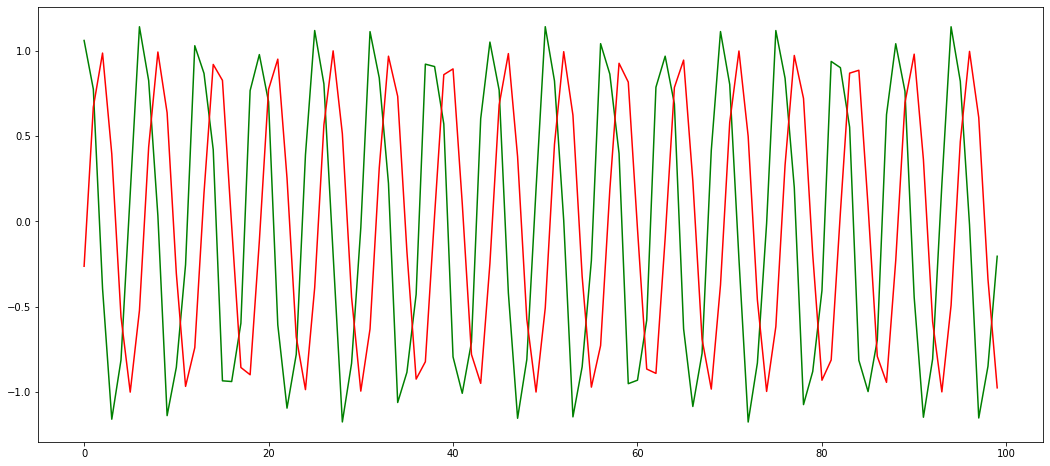

In [9]:
# do a forward pass through the trained weights to get our predictions for the training data

preds = []
for i in range(Y.shape[0]):
    x, y = X[i], Y[i]
    prev_s = np.zeros((hidden_dim, 1))
    # Forward pass
    for t in range(T):
        mulu = np.dot(U, x)
        mulw = np.dot(W, prev_s)
        add = mulw + mulu
        s = sigmoid(add)
        mulv = np.dot(V, s)
        prev_s = s

    preds.append(mulv)
    
preds = np.array(preds)

# plot the predictions alongside the actual values
plt.plot(preds[:, 0, 0], 'g')
plt.plot(Y[:, 0], 'r')
plt.show()

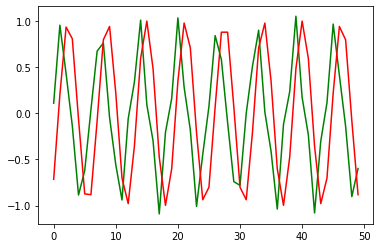

In [49]:
# now for the validation data

preds = []
for i in range(Y_val.shape[0]):
    x, y = X_val[i], Y_val[i]
    prev_s = np.zeros((hidden_dim, 1))
    # For each time step...
    for t in range(T):
        mulu = np.dot(U, x)
        mulw = np.dot(W, prev_s)
        add = mulw + mulu
        s = sigmoid(add)
        mulv = np.dot(V, s)
        prev_s = s

    preds.append(mulv)
    
preds = np.array(preds)

plt.plot(preds[:, 0, 0], 'g')
plt.plot(Y_val[:, 0], 'r')
plt.show()